# <center> LAB 03: Backpropagation in Multilayer Neural Networks<br> <small>Réda DEHAK<br> 06 January 2021</small> </center>

The goal of this lab is :

    - Understand neural networks and their layered architectures,
    - Understand and implement backpropagation in `Numpy`

## Part 1: Simple Case 2D problem 
### Import Data

We will use the Wine dataset from UCI. These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars. The analysis determined the quantities of thirteen constituents found in each of the three types of wines.

# Loading and Plotting Data
 
First, we will use only two features from the data set: alcohol and ash (We can plot the solution in 2D space). The labels are supplied as an array of data with values from 1 to 3.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('data.txt')

X = data[['alcohol', 'flavanoids']].to_numpy()
y = data[['class']].to_numpy().flatten() - 1

In [2]:
# split data into train and validation set
from sklearn.model_selection import train_test_split

# We fixe the random_state to have the same split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
print('train:', len(X_train), 'test:', len(X_test))

train: 133 test: 45


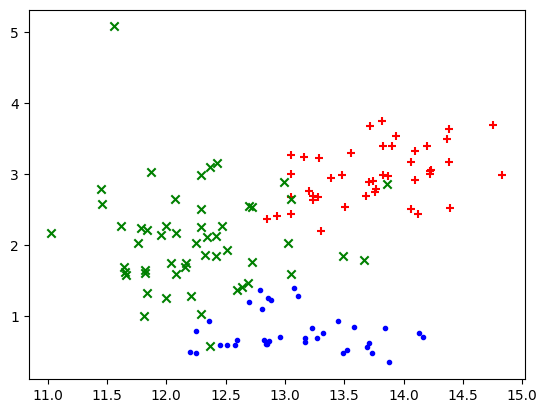

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

MARKERS = ['+', 'x', '.']
COLORS = ['red', 'green', 'blue']

def plot_points(xy, labels):
    
    for i, label in enumerate(set(labels)):
        points = np.array([xy[j,:] for j in range(len(xy)) if labels[j] == label])
        marker = MARKERS[i % len(MARKERS)]
        color = COLORS[i % len(COLORS)]
        plt.scatter(points[:,0], points[:,1], marker=marker, color=color)

plot_points(X_train, y_train.flatten())

### Preprocessing

- Normalization
- Train / test split

In [4]:
from sklearn import preprocessing

# Data Normalization: mean = 0; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(scaler.mean_)
print(scaler.scale_)

[12.97285714  2.02120301]
[0.82686706 1.00174963]


In [5]:
X_train.shape

(133, 2)

In [6]:
X_train.dtype

dtype('float64')

In [7]:
X_test.shape

(45, 2)

In [8]:
X_test.dtype

dtype('float64')

In [9]:
y_train.shape

(133,)

In [10]:
y_train.dtype

dtype('int64')

### One-hot encoding for class label data

First let's define a helper function to compute the one hot encoding of an integer array for a fixed number of classes (similar to keras' `to_categorical`):

In [11]:
def one_hot(y, num_classes):
    return np.eye(num_classes)[y]

In [12]:
from tensorflow.keras.utils import to_categorical
to_categorical(3, num_classes=5)

2024-04-05 10:08:23.550677: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


array([0., 0., 0., 1., 0.])

In [13]:
one_hot(y=3, num_classes=5)

array([0., 0., 0., 1., 0.])

In [14]:
to_categorical([0, 4, 9, 1], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [15]:
one_hot(y=[0, 4, 9, 1], num_classes=10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

### The softmax function

Now let's implement the softmax vector function:

$$
softmax(\mathbf{x}) = \frac{1}{\sum_{i=1}^{n}{e^{x_i}}}
\cdot
\begin{bmatrix}
  e^{x_1}\\\\
  e^{x_2}\\\\
  \vdots\\\\
  e^{x_n}
\end{bmatrix}
$$

In [16]:
def softmax(X):
    t = np.exp(X)
    return t / np.sum(t, axis=-1, keepdims=True)

Make sure that this works one vector at a time (and check that the components sum to one):

In [17]:
print(softmax([10, 2, -3]))
print(np.sum(softmax([10, 2, -3])))

[9.99662391e-01 3.35349373e-04 2.25956630e-06]
1.0


Note that a naive implementation of softmax might not be able process a batch of activations in a single call:

In [18]:
X = np.array([[10, 2, -3],
              [-1, 5, -20]])
print(softmax(X))
print(np.sum(softmax(X), axis=-1))

[[9.99662391e-01 3.35349373e-04 2.25956630e-06]
 [2.47262316e-03 9.97527377e-01 1.38536042e-11]]
[1. 1.]


Implement a function that given the true one-hot encoded class `Y_true` and some predicted probabilities `Y_pred` returns the negative log likelihood.

In [19]:
EPS = 1E-5
def nllk(Y_true, Y_pred):
    Y_true = np.asarray(Y_true)
    Y_pred = np.asarray(Y_pred)
    return -1/len(Y_true) * np.sum(Y_true * np.log(Y_pred + EPS)) 


# Make sure that it works for a simple sample at a time
print(nllk([1, 0, 0], [.99, 0.01, 0]))

0.0033467449648051147


Check that the nll of a very confident yet bad prediction is a much higher positive number:

In [20]:
print(nllk([1, 0, 0], [0.01, 0.01, .98]))

1.5347235618850026


Implement the `sigmoid` and its element-wise derivative `dsigmoid` functions:

$$
sigmoid(x) = \frac{1}{1 + e^{-x}}
$$

$$
dsigmoid(x) = sigmoid(x) \cdot (1 - sigmoid(x))
$$

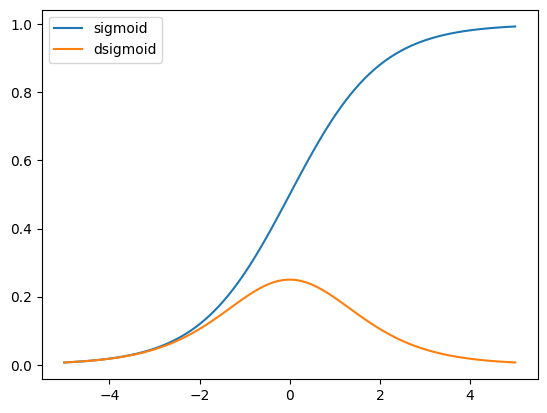

In [21]:
def sigmoid(X):
    return 1 / (1+ np.exp(-X)) 


def dsigmoid(X):
    t = sigmoid(X)
    return t * (1 - t)


x = np.linspace(-5, 5, 100)
plt.plot(x, sigmoid(x), label='sigmoid')
plt.plot(x, dsigmoid(x), label='dsigmoid')
plt.legend(loc='best');

- Implement `forward` and `forward_keep_all` functions for a model with a hidden layer with a sigmoid activation function:
  - $\mathbf{h} = sigmoid\left(\mathbf{W}_h^T \hat{\mathbf{x}}\right)$
  - $\mathbf{y} = softmax\left(\mathbf{W}_o^T \hat{\mathbf{h}}\right)$

- Notes: 
  - `forward_keep_activations` is similar to forward, but also returns hidden activations and pre activations;

- Implement the grad function to compute all gradients; check that the gradients are well defined;

- Implement the `train` and `loss` functions.

In [22]:
a=np.zeros((3,4))

In [23]:
np.ones((3,1))

array([[1.],
       [1.],
       [1.]])

In [24]:
np.hstack((np.ones((3,1)), a))

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [38]:
EPSILON = 1e-8

class NeuralNet():
    """MLP with 1 hidden layer with a sigmoid activation"""
    
    def __init__(self, input_size, hidden_size, output_size):
        # TODO
        self.W_h = np.random.uniform(size=(input_size + 1, hidden_size), high=0.01, low=-0.01)     
        self.W_o = np.random.uniform(size=(hidden_size + 1, output_size), high=0.01, low=-0.01)  
        self.output_size = output_size
        
    def forward(self, X):
        X = np.atleast_2d(X)
        
        # First Layer
        Inh = np.hstack((np.ones((len(X), 1)), X))
        Zh = Inh @ self.W_h
        Oh = sigmoid(Zh)
        
        # Second Layer
        InO = np.hstack((np.ones((len(Oh), 1)), Oh))
        Zo = InO @ self.W_o
        Oo = softmax(Zo)
        
        return Oo
    
    def forward_keep_activations(self, X):
        X = np.atleast_2d(X)
        
        # First Layer
        Inh = np.hstack((np.ones((len(X), 1)), X))
        Zh = Inh @ self.W_h
        Oh = sigmoid(Zh)
        
        # Second Layer
        InO = np.hstack((np.ones((len(Oh), 1)), Oh))
        Zo = InO @ self.W_o
        Oo = softmax(Zo)
        
        return Oo, InO, Zh, Inh
    
    def loss(self, X, y):
        return nllk(one_hot(y, num_classes=self.output_size), self.forward(X))

    def grad_loss(self, x, y_true):
        x = np.atleast_2d(x)
        N = x.shape[0]
        y = one_hot(y_true, num_classes=self.output_size)

        Oo, InO, Zh, Inh = self.forward_keep_activations(x)
        # Output Layer

        dEdZo = (Oo - y)
        dEdWo = InO.T @ dEdZo

        # First Layer
        dEdZh = dsigmoid(Zh) * (dEdZo @ self.W_o[1:, :].T)
        dEdWh = Inh.T @ dEdZh
        
        return {"dEdW_h": dEdWh / N, "dEdW_o": dEdWo / N }

    
    def train(self, x, y, learning_rate, l2 = 0.):
        # One step of Backpropagation on x
        # l2 is the L2 regularization coefficient 
        # TODO
        grad = self.grad_loss(x, y)
        l2wh = l2 * self.W_h
        l2wh[0, :] = 0 #  bias is not regularized
        self.W_h = self.W_h - learning_rate * (grad["dEdW_h"] + l2wh)
        l2wo = l2 * self.W_o
        l2wo[0, :] = 0 #  bias is not regularized
        self.W_o = self.W_o - learning_rate * (grad["dEdW_o"] + l2wo)

    def predict(self, X):
        if len(X) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

Use the class NeuralNet to train a classifier on Wine Dataset, try different values for n_hidden (1,2,3 and 5), different Learning rate (0.1, 1, .5 and .01) and different l2 (0, 0.001, 0.005, 0.01) see the difference

In [39]:
n_hidden = 5
n_features = 2
n_classes = 3
modelWine = NeuralNet(n_features, n_hidden, n_classes)

In [40]:
modelWine.loss(X_train, y_train)

1.0983490653874257

In [41]:
modelWine.accuracy(X_train, y_train)

0.39849624060150374

In [42]:
losses, accuracies, accuracies_test = [], [], []
print(modelWine.loss(X_train, y_train))
losses.append(modelWine.loss(X_train, y_train))
accuracies.append(modelWine.accuracy(X_train, y_train))
accuracies_test.append(modelWine.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    
    for i in np.arange(X_train.shape[0]):
        modelWine.train(X_train[i, :], y_train[i], .1)
    losses.append(modelWine.loss(X_train, y_train))
    accuracies.append(modelWine.accuracy(X_train, y_train))
    accuracies_test.append(modelWine.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

1.0983490653874257
Random init: train loss: 1.09835, train acc: 0.398, test acc: 0.400
Epoch #1, train loss: 1.12599, train acc: 0.398, test acc: 0.400
Epoch #2, train loss: 1.09703, train acc: 0.398, test acc: 0.400
Epoch #3, train loss: 0.89397, train acc: 0.398, test acc: 0.400
Epoch #4, train loss: 0.58357, train acc: 0.752, test acc: 0.889
Epoch #5, train loss: 0.42030, train acc: 0.857, test acc: 0.933
Epoch #6, train loss: 0.33804, train acc: 0.910, test acc: 0.911
Epoch #7, train loss: 0.29374, train acc: 0.910, test acc: 0.933
Epoch #8, train loss: 0.26756, train acc: 0.925, test acc: 0.933
Epoch #9, train loss: 0.25059, train acc: 0.932, test acc: 0.933
Epoch #10, train loss: 0.23868, train acc: 0.932, test acc: 0.933
Epoch #11, train loss: 0.22977, train acc: 0.932, test acc: 0.933
Epoch #12, train loss: 0.22276, train acc: 0.932, test acc: 0.933
Epoch #13, train loss: 0.21704, train acc: 0.932, test acc: 0.933
Epoch #14, train loss: 0.21222, train acc: 0.932, test acc: 0.93

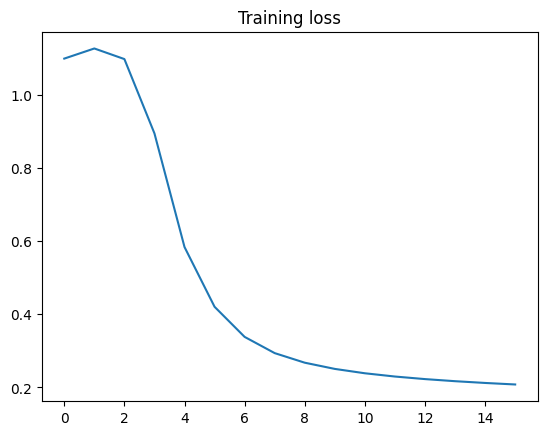

In [43]:
plt.plot(losses)
plt.title("Training loss");

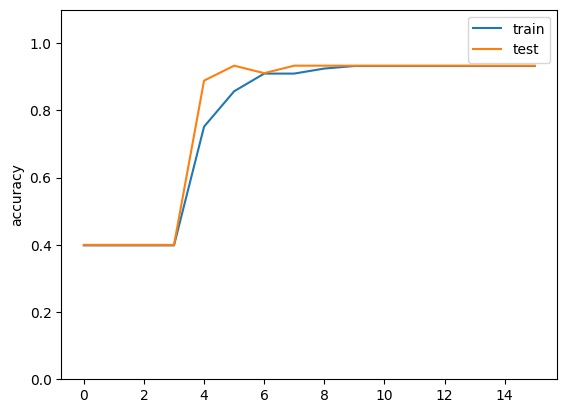

In [44]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

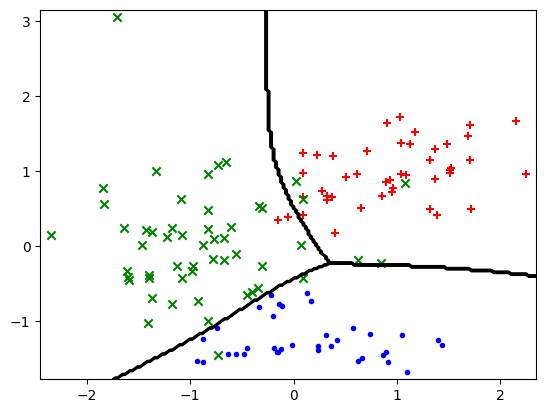

In [45]:
def plot_boundary(X, pred):
    
    x_min, x_max = X[:,0].min() - .1, X[:,0].max() + .1
    y_min, y_max = X[:,1].min() - .1, X[:,1].max() + .1
    
    xs, ys = np.meshgrid(
        np.linspace(x_min, x_max, 200),
        np.linspace(y_min, y_max, 200)
    )

    xys = np.column_stack([xs.ravel(), ys.ravel()])
    zs = pred(xys).reshape(xs.shape)
    plt.contour(xs, ys, zs, colors='black')

plot_points(X_train, y_train.flatten())
plot_boundary(X_train, lambda x: modelWine.predict(x))

### Mini-batches

- The current implementations of `train` and `grad_loss` function currently only accept a single sample at a time:
    - implement MiniBatchNeuralNet class which supports training with a mini-batch of batch_size samples at a time instead of one,

In [56]:
n_hidden = 5
n_features = 2
n_classes = 3
modelWine2 = NeuralNet(n_features, n_hidden, n_classes)

losses, accuracies, accuracies_test = [], [], []
print(modelWine2.loss(X_train, y_train))
losses.append(modelWine2.loss(X_train, y_train))
accuracies.append(modelWine2.accuracy(X_train, y_train))
accuracies_test.append(modelWine2.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

batch_size = 16
N = X_train.shape[0]
for epoch in range(150):
    idx = np.arange(X_train.shape[0])
    for batchid in range(int(np.ceil(N/batch_size))):
        batch = idx[batchid * batch_size:min(((batchid + 1) * batch_size), N)]
        modelWine2.train(X_train[batch, :], y_train[batch], .1)
    losses.append(modelWine2.loss(X_train, y_train))
    accuracies.append(modelWine2.accuracy(X_train, y_train))
    accuracies_test.append(modelWine2.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

1.0992503594306724
Random init: train loss: 1.09925, train acc: 0.331, test acc: 0.333
Epoch #1, train loss: 1.08719, train acc: 0.398, test acc: 0.400
Epoch #2, train loss: 1.08701, train acc: 0.398, test acc: 0.400
Epoch #3, train loss: 1.08814, train acc: 0.398, test acc: 0.400
Epoch #4, train loss: 1.08888, train acc: 0.398, test acc: 0.400
Epoch #5, train loss: 1.08918, train acc: 0.398, test acc: 0.400
Epoch #6, train loss: 1.08922, train acc: 0.398, test acc: 0.400
Epoch #7, train loss: 1.08910, train acc: 0.398, test acc: 0.400
Epoch #8, train loss: 1.08890, train acc: 0.398, test acc: 0.400
Epoch #9, train loss: 1.08864, train acc: 0.398, test acc: 0.400
Epoch #10, train loss: 1.08833, train acc: 0.398, test acc: 0.400
Epoch #11, train loss: 1.08798, train acc: 0.398, test acc: 0.400
Epoch #12, train loss: 1.08758, train acc: 0.398, test acc: 0.400
Epoch #13, train loss: 1.08713, train acc: 0.398, test acc: 0.400
Epoch #14, train loss: 1.08662, train acc: 0.398, test acc: 0.40

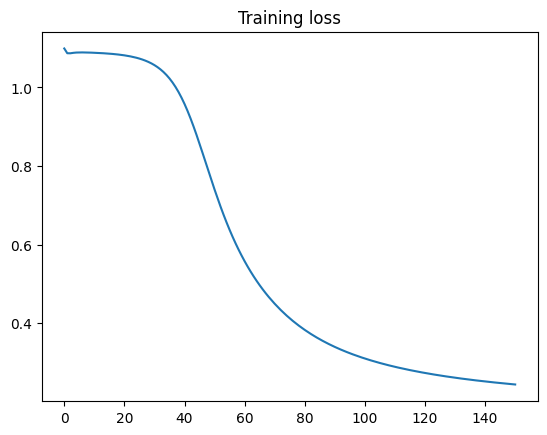

In [57]:
plt.plot(losses)
plt.title("Training loss");

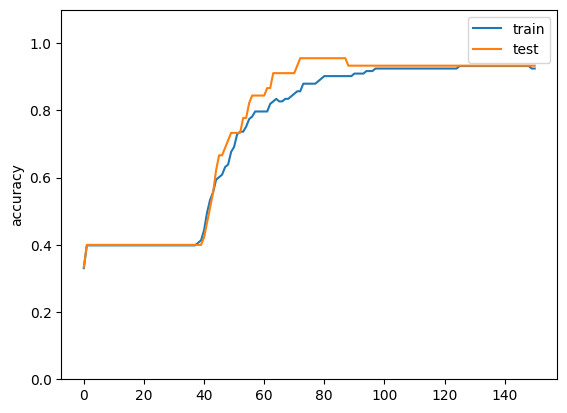

In [58]:
plt.plot(accuracies, label='train')
plt.plot(accuracies_test, label='test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc='best');

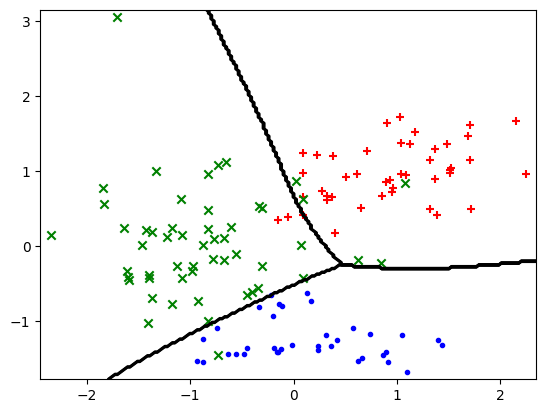

In [59]:
plot_points(X_train, y_train.flatten())
plot_boundary(X_train, lambda x: modelWine2.predict(x))

    - experiment with different sizes of batches,
    - monitor the norm of the average gradients on the full training set at the end of each epoch.

In [60]:
n_hidden = 5
n_features = 2
n_classes = 3
modelWine2 = NeuralNet(n_features, n_hidden, n_classes)

losses, accuracies, accuracies_test = [], [], []
print(modelWine2.loss(X_train, y_train))
losses.append(modelWine2.loss(X_train, y_train))
accuracies.append(modelWine2.accuracy(X_train, y_train))
accuracies_test.append(modelWine2.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

batch_size = 64
N = X_train.shape[0]
for epoch in range(150):
    idx = np.arange(X_train.shape[0])
    for batchid in range(int(np.ceil(N/batch_size))):
        batch = idx[batchid * batch_size:min(((batchid + 1) * batch_size), N)]
        modelWine2.train(X_train[batch, :], y_train[batch], .1)
    losses.append(modelWine2.loss(X_train, y_train))
    accuracies.append(modelWine2.accuracy(X_train, y_train))
    accuracies_test.append(modelWine2.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

1.0993857483902887
Random init: train loss: 1.09939, train acc: 0.271, test acc: 0.267
Epoch #1, train loss: 1.08906, train acc: 0.398, test acc: 0.400
Epoch #2, train loss: 1.08719, train acc: 0.398, test acc: 0.400
Epoch #3, train loss: 1.08958, train acc: 0.398, test acc: 0.400
Epoch #4, train loss: 1.09378, train acc: 0.398, test acc: 0.400
Epoch #5, train loss: 1.09842, train acc: 0.398, test acc: 0.400
Epoch #6, train loss: 1.10286, train acc: 0.398, test acc: 0.400
Epoch #7, train loss: 1.10680, train acc: 0.398, test acc: 0.400
Epoch #8, train loss: 1.11015, train acc: 0.398, test acc: 0.400
Epoch #9, train loss: 1.11294, train acc: 0.398, test acc: 0.400
Epoch #10, train loss: 1.11522, train acc: 0.398, test acc: 0.400
Epoch #11, train loss: 1.11706, train acc: 0.398, test acc: 0.400
Epoch #12, train loss: 1.11853, train acc: 0.398, test acc: 0.400
Epoch #13, train loss: 1.11969, train acc: 0.398, test acc: 0.400
Epoch #14, train loss: 1.12061, train acc: 0.398, test acc: 0.40

### Bonus: Hyper parameters settings

  - Add more hidden layer

In [ ]:
class MoreHiddenLayersNeuralNet(NeuralNet):
    """MLP with K hidden layers with a sigmoid activation Using Mini Batch Learning"""
    
    def __init__(self, input_size, hidden_size, output_size):
        self.activationf = []
        self.dactivationf = []
        self.Ws = []
        self.Ws.append(np.random.uniform(size=(input_size + 1, hidden_size[0]), high=0.01, low=-0.01))
        self.activationf.append(lambda x : sigmoid(x))
        self.dactivationf.append(lambda x : dsigmoid(x))
        
        for i in range(1, len(hidden_size)):
            # Layer i
            W = np.random.uniform(size=(hidden_size[i-1] + 1, hidden_size[i]), high=0.01, low=-0.01)
            self.Ws.append(W)
            if i == len(hidden_size) - 1 :
                self.activationf.append(lambda x: softmax(x))
            else
                self.activationf.append(lambda x: sigmoid(x))
                self.dactivationf.append(lambda x: dsigmoid(x))
          
        self.output_size = output_size
        self.NbLayers = len(hidden_size)
        
    def forward(self, X):
        X = np.atleast_2d(X)
        
        # First Layer
        Inh = np.hstack((np.ones((len(X), 1)), X))
        Zh = Inh @ self.W_h
        Oh = sigmoid(Zh)
        
        # Second Layer
        InO = np.hstack((np.ones((len(Oh), 1)), Oh))
        Zo = InO @ self.W_o
        Oo = softmax(Zo)
        
        return Oo
    
    def forward_keep_activations(self, X):
        X = np.atleast_2d(X)
        
        # First Layer
        Inh = np.hstack((np.ones((len(X), 1)), X))
        Zh = Inh @ self.W_h
        Oh = sigmoid(Zh)
        
        # Second Layer
        InO = np.hstack((np.ones((len(Oh), 1)), Oh))
        Zo = InO @ self.W_o
        Oo = softmax(Zo)
        
        return Oo, InO, Zh, Inh
    
    def loss(self, X, y):
        return nllk(one_hot(y, num_classes=self.output_size), self.forward(X))

    def grad_loss(self, x, y_true):
        x = np.atleast_2d(x)
        N = x.shape[0]
        y = one_hot(y_true, num_classes=self.output_size)

        Oo, InO, Zh, Inh = self.forward_keep_activations(x)
        # Output Layer

        dEdZo = (Oo - y)
        dEdWo = InO.T @ dEdZo

        # First Layer
        dEdZh = dsigmoid(Zh) * (dEdZo @ self.W_o[1:, :].T)
        dEdWh = Inh.T @ dEdZh
        
        return {"dEdW_h": dEdWh / N, "dEdW_o": dEdWo / N }

    
    def train(self, x, y, learning_rate, l2 = 0.):
        # One step of Backpropagation on x
        # l2 is the L2 regularization coefficient 
        # TODO
        grad = self.grad_loss(x, y)
        l2wh = l2 * self.W_h
        l2wh[0, :] = 0 #  bias is not regularized
        self.W_h = self.W_h - learning_rate * (grad["dEdW_h"] + l2wh)
        l2wo = l2 * self.W_o
        l2wo[0, :] = 0 #  bias is not regularized
        self.W_o = self.W_o - learning_rate * (grad["dEdW_o"] + l2wo)

    def predict(self, X):
        if len(X) == 1:
            return np.argmax(self.forward(X))
        else:
            return np.argmax(self.forward(X), axis=1)

    def accuracy(self, X, y):
        y_preds = np.argmax(self.forward(X), axis=1)
        return np.mean(y_preds == y)

### Bonus: Hyper parameters settings

- Experiment with different hyper parameters:
  - learning rate,
  - size of hidden layer,
  - initialization scheme: test with 0 initialization vs uniform,
  - implement other activation functions,
  - implement the support for a second hidden layer

### Momentum

- Bonus: Implement momentum

## Part2: Digit Dataset

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_digits

digits = load_digits()

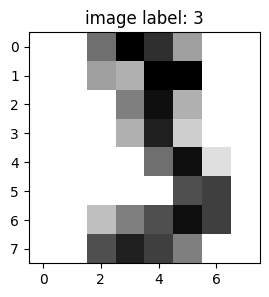

In [14]:
sample_index = 45
plt.figure(figsize=(3, 3))
plt.imshow(digits.images[sample_index], cmap=plt.cm.gray_r,
           interpolation='nearest')
plt.title("image label: %d" % digits.target[sample_index]);

### Preprocessing

- Normalization
- Train / test split

In [15]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

data = np.asarray(digits.data, dtype='float32')
target = np.asarray(digits.target, dtype='int32')

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.15, random_state=37)

# mean = 0 ; standard deviation = 1.0
scaler = preprocessing.StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(scaler.mean_)
print(scaler.scale_)

[0.00000000e+00 2.98624754e-01 5.19253438e+00 1.18428291e+01
 1.18565815e+01 5.81008513e+00 1.34774067e+00 1.19187950e-01
 6.54878847e-03 1.99345121e+00 1.03464309e+01 1.19305828e+01
 1.02626064e+01 8.20497708e+00 1.84348396e+00 9.88867060e-02
 3.27439424e-03 2.61624100e+00 9.83497053e+00 6.87098887e+00
 7.11263916e+00 7.83759005e+00 1.75376555e+00 4.45317616e-02
 1.30975769e-03 2.48788474e+00 9.04453176e+00 8.73280943e+00
 9.98231827e+00 7.57105435e+00 2.26850033e+00 2.61951539e-03
 0.00000000e+00 2.36149312e+00 7.68369352e+00 9.07924034e+00
 1.03713163e+01 8.79240341e+00 2.89980354e+00 0.00000000e+00
 8.51342502e-03 1.57039948e+00 6.84937787e+00 7.22855272e+00
 7.65029470e+00 8.26522593e+00 3.48592010e+00 2.61951539e-02
 8.51342502e-03 6.83693517e-01 7.49312377e+00 9.56516045e+00
 9.36869679e+00 8.77668631e+00 3.76686313e+00 2.08906352e-01
 6.54878847e-04 2.78978389e-01 5.53700065e+00 1.20595940e+01
 1.17832351e+01 6.81990832e+00 2.07465619e+00 3.42501637e-01]
[1.         0.91047426 

In [16]:
X_train.shape

(1527, 64)

In [17]:
X_train.dtype

dtype('float32')

In [18]:
X_test.shape

(270, 64)

In [19]:
X_test.dtype

dtype('float32')

In [20]:
y_train.shape

(1527,)

In [21]:
y_train.dtype

dtype('int32')

In [ ]:
n_hidden = 10
n_classes = 10
n_features = 64
modelDigit = NeuralNet(n_features, n_hidden, n_classes)

In [ ]:
modelDigit.loss(X_train, y_train)

In [ ]:
modelDigit.accuracy(X_train, y_train)

In [ ]:
print(modelDigit.forward(X_test[5]))

In [ ]:
print(modelDigit.predict(X_test[5]))

In [ ]:
def plot_prediction(forward_fun, sample_idx = 0, classes = range(10)):
    fig, (ax0, ax1) = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

    ax0.imshow(scaler.inverse_transform(X_test[sample_idx]).reshape(8, 8), cmap = plt.cm.gray_r,
               interpolation = 'nearest')
    ax0.set_title("True image label: %d" % y_test[sample_idx]);


    ax1.bar(classes, one_hot(y_test[sample_idx], num_classes=len(classes)), label = 'true')
    probas = forward_fun(np.array(X_test[sample_idx])[np.newaxis]).ravel()
    ax1.bar(classes, probas, label = 'prediction', color = "red")
    ax1.set_xticks(classes)
    prediction = probas.argmax(axis=-1)
    ax1.set_title('Output probabilities (prediction: %d)'
                  % prediction)
    ax1.set_xlabel('Digit class')
    ax1.legend()

plot_prediction(modelDigit.forward, sample_idx=5)

In [ ]:
losses, accuracies, accuracies_test = [], [], []
losses.append(modelDigit.loss(X_train, y_train))
accuracies.append(modelDigit.accuracy(X_train, y_train))
accuracies_test.append(modelDigit.accuracy(X_test, y_test))

print("Random init: train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
      % (losses[-1], accuracies[-1], accuracies_test[-1]))

for epoch in range(15):
    for i, (x, y) in enumerate(zip(X_train, y_train)):
        modelDigit.train(x, y, 0.1)

    losses.append(modelDigit.loss(X_train, y_train))
    accuracies.append(modelDigit.accuracy(X_train, y_train))
    accuracies_test.append(modelDigit.accuracy(X_test, y_test))
    print("Epoch #%d, train loss: %0.5f, train acc: %0.3f, test acc: %0.3f"
          % (epoch + 1, losses[-1], accuracies[-1], accuracies_test[-1]))

In [ ]:
plt.plot(losses)
plt.title("Training loss");

In [ ]:
plt.plot(accuracies, label = 'train')
plt.plot(accuracies_test, label = 'test')
plt.ylim(0, 1.1)
plt.ylabel("accuracy")
plt.legend(loc = 'best');

In [ ]:
plot_prediction(modelDigit.forward, sample_idx = 5)

### Look at worst prediction errors

- Use numpy to find test samples for which the model made the worst predictions,
- Use the `plot_prediction` to look at the model predictions on those,
- Would you have done any better?

### Back to Keras

- You can now use keras to implement and train the same network architecture

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

n_features = 8 * 8
n_classes = 10
n_hidden = 10

keras_model = Sequential()
keras_model.add(Dense(n_hidden, input_dim = n_features, activation = 'sigmoid'))
keras_model.add(Dense(n_classes, activation = 'softmax'))

keras_model.compile(optimizer = SGD(learning_rate = 3),
                    loss='categorical_crossentropy', metrics=['accuracy'])

keras_model.fit(X_train, to_categorical(y_train), epochs = 15, batch_size = 16) 

- Check that the Keras model can approximately reproduce the behavior of the Numpy model when using similar hyperparameter values (size of the model, type of activations, learning rate value and use of momentum).

- Compute the negative log likelihood of a sample 42 in the test set (can use model.predict_proba

- Compute the average negative log-likelihood on the full test set.

- Compute the average negative log-likelihood on the full training set and check that you can get the value of the loss reported by Keras.

- Using keras, add a second hidden Layer to keras_model model and learn the hyper parameters.

- Is the model overfitting or underfitting? (ensure that the model has fully converged by increasing the number of epochs to 50 or more if necessary).